In [147]:
import pandas as pd
import numpy as np
import random
import pickle
from typing import Dict, List
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [148]:

import joblib
prakriti_model = joblib.load('/content/prakriti_model_robust.pkl')
X_stage1 = pd.read_pickle('/content/stage1_input_features.pkl')  # encoded input features
prakriti_predictions = prakriti_model.predict(X_stage1)

In [149]:
# ✅ Clean Seed Setup
seed = int(datetime.now().timestamp())
random.seed(seed)
np.random.seed(seed)

# Constants
NUM_RECORDS = 10000
GENDERS = ['Male', 'Female']
DIET_TYPES = ['Balanced', 'Irregular', 'Junk']
SLEEP_QUALITY = ['Good', 'Average', 'Poor']
STRESS_LEVELS = ['Low', 'Medium', 'High']
PHYSICAL_ACTIVITY = ['Active', 'Moderate', 'Sedentary']
MEMORY_LOSS = ['None', 'Mild', 'Severe']
CONFUSION = ['Rare', 'Sometimes', 'Often']
LANGUAGE_DIFFICULTY = ['No', 'Mild', 'Yes']
DECISION_MAKING = ['Sharp', 'Indecisive', 'Poor']
REP_BEHAVIOR = ['No', 'Sometimes', 'Yes']
SOCIAL_WITHDRAWAL = ['No', 'Sometimes', 'Yes']
MOOD_SWINGS = ['No', 'Sometimes', 'Yes']
CHRONIC_CONDITIONS = ['None', 'Diabetes', 'BP', 'Both']

AYURVEDA_REC = {
    'Vata': 'Brahmi, Ashwagandha, Abhyanga massage, warm diet',
    'Pitta': 'Shankhpushpi, Gotu Kola, cooling herbs, meditation',
    'Kapha': 'Triphala, Guggulu, Panchakarma, light diet'
}

ALLOPATHY_REC = {
    'Low': 'Annual wellness exam, cognitive screening',
    'Medium': 'Memory clinic referral, neurology consultation',
    'High': 'MRI brain scan, neuropsychological testing, therapy'
}
# ... your constants here ...

def maybe_flip(value, options, prob=0.1):
    """Randomly flip value to another in the options list with given probability."""
    if random.random() < prob:
        return random.choice([opt for opt in options if opt != value])
    return value


def load_prakriti_data(file_path: str) -> List[str]:
    """Load pre-predicted Prakriti types from .pkl file."""
    try:
        with open(file_path, 'rb') as f:
            prakriti_list = pickle.load(f)
        if len(prakriti_list) != NUM_RECORDS:
            raise ValueError("Number of Prakriti records does not match expected count.")
        return prakriti_list
    except Exception as e:
        raise SystemExit(f"Error loading Prakriti  {e}")

def generate_patient_ids(n: int) -> List[str]:
    return [f"PAT{i+1000}" for i in range(n)]

def get_chronic_condition() -> str:
    return random.choices(CHRONIC_CONDITIONS, weights=[40, 25, 25, 10], k=1)[0]

def get_systolic_bp(prakriti: str) -> int:
    if prakriti == 'Kapha':
        return random.randint(120, 160)
    elif prakriti == 'Vata':
        return random.randint(90, 130)
    else:
        return random.randint(100, 140)

def get_blood_sugar(prakriti: str) -> int:
    if prakriti == 'Kapha':
        return random.randint(90, 200)
    elif prakriti == 'Vata':
        return random.randint(70, 130)
    else:
        return random.randint(80, 150)

def get_bmi(prakriti: str) -> float:
    if prakriti == 'Kapha':
        return round(random.uniform(25, 35), 1)
    elif prakriti == 'Vata':
        return round(random.uniform(16, 24), 1)
    else:
        return round(random.uniform(18, 28), 1)

def calculate_risk_score(row):
    score = 0
    if row['age'] > 65: score += 10
    if row['memory_loss'] == 'Mild': score += 15
    elif row['memory_loss'] == 'Severe': score += 20
    if row['confusion'] == 'Sometimes': score += 10
    elif row['confusion'] == 'Often': score += 15
    if row['language_difficulty'] == 'Mild': score += 5
    elif row['language_difficulty'] == 'Yes': score += 10
    if row['decision_making'] == 'Indecisive': score += 5
    elif row['decision_making'] == 'Poor': score += 10
    if row['repetition_behavior'] == 'Sometimes': score += 5
    elif row['repetition_behavior'] == 'Yes': score += 8
    if row['social_withdrawal'] == 'Sometimes': score += 5
    elif row['social_withdrawal'] == 'Yes': score += 7
    if row['mood_swings'] == 'Sometimes': score += 3
    elif row['mood_swings'] == 'Yes': score += 5
    if row['stress_level'] == 'Medium': score += 5
    elif row['stress_level'] == 'High': score += 8
    if row['sleep_quality'] == 'Poor': score += 7
    if row['physical_activity'] == 'Sedentary': score += 5
    if row['diet_type'] == 'Junk': score += 5
    if row['chronic_conditions'] in ['Diabetes', 'BP']: score += 10
    elif row['chronic_conditions'] == 'Both': score += 10
    if row['family_history'] == 'Yes': score += 10
    if row['systolic_bp'] > 140: score += 5
    if row['blood_sugar'] > 130: score += 5
    if row['bmi'] < 18 or row['bmi'] > 30: score += 5
    if row['prakriti_type'] == 'Vata': score *= 1.1
    elif row['prakriti_type'] == 'Kapha': score *= 1.05

    # Cap at 125, then normalize to 100
    score = min(score, 125)
    return round((score / 125) * 100, 2)


def get_risk_level(score: float) -> str:
    if score <= 40:
        return "Low"
    elif 41 <= score <= 60:
        return "Medium"
    else:
        return "High"


def get_verdict(score: float) -> str:
    if score <= 40:
        return "Healthy but monitor"
    elif 41 <= score <= 60:
        return "Needs attention"
    else:
        return "High risk, take action"


def get_recommendations(prakriti: str, risk_level: str) -> tuple:
    ayurveda = AYURVEDA_REC[prakriti]
    allopathy = ALLOPATHY_REC[risk_level]
    return ayurveda, allopathy


patient_ids = generate_patient_ids(NUM_RECORDS)


prakriti_mapping = {
    0: 'Vata',
    1: 'Pitta',
    2: 'Kapha'
}


data = []
print("🔄 Generating dataset using Stage 1 Prakriti predictions...")

for pid, prakriti_num in zip(patient_ids, prakriti_predictions):

    prakriti = prakriti_mapping.get(prakriti_num, 'Unknown')

    age = int(np.random.normal(60, 12))
    age = max(min(age, 90), 20)
    gender = random.choice(GENDERS)
    diet = random.choices(DIET_TYPES, weights=[40, 30, 30], k=1)[0]
    sleep = random.choices(SLEEP_QUALITY, weights=[40, 35, 25], k=1)[0]
    stress = random.choices(STRESS_LEVELS, weights=[40, 35, 25], k=1)[0]
    activity = random.choices(PHYSICAL_ACTIVITY, weights=[35, 40, 25], k=1)[0]

    diet = maybe_flip(diet, DIET_TYPES, prob=0.1)
    sleep = maybe_flip(sleep, SLEEP_QUALITY, prob=0.1)
    stress = maybe_flip(stress, STRESS_LEVELS, prob=0.1)
    activity = maybe_flip(activity, PHYSICAL_ACTIVITY, prob=0.1)

    chronic = get_chronic_condition()
    systolic_bp = get_systolic_bp(prakriti)
    blood_sugar = get_blood_sugar(prakriti)
    bmi = get_bmi(prakriti)
    family = random.choice(['Yes', 'No'])

    memory_loss = random.choices(MEMORY_LOSS, weights=[60, 30, 10], k=1)[0]
    confusion = random.choices(CONFUSION, weights=[60, 25, 15], k=1)[0]
    memory_loss = maybe_flip(memory_loss, MEMORY_LOSS, prob=0.1)
    confusion = maybe_flip(confusion, CONFUSION, prob=0.1)
    language_difficulty = random.choices(LANGUAGE_DIFFICULTY, weights=[70, 20, 10], k=1)[0]
    # language_difficulty = random.choices(LANGUAGE_DIFFICULTY, weights=[70, 20, 10], k=1)[0]
    decision_making = random.choices(DECISION_MAKING, weights=[60, 25, 15], k=1)[0]
    repetition_behavior = random.choices(REP_BEHAVIOR, weights=[70, 20, 10], k=1)[0]
    social_withdrawal = random.choices(SOCIAL_WITHDRAWAL, weights=[70, 20, 10], k=1)[0]
    mood_swings = random.choices(MOOD_SWINGS, weights=[70, 20, 10], k=1)[0]


    symptom_score = 0
    symptom_score += {'None': 0, 'Mild': 10, 'Severe': 15}[memory_loss]
    symptom_score += {'Rare': 0, 'Sometimes': 5, 'Often': 8}[confusion]
    symptom_score += {'No': 0, 'Mild': 3, 'Yes': 5}[language_difficulty]
    symptom_score += {'Sharp': 0, 'Indecisive': 3, 'Poor': 5}[decision_making]

    row = {
        'patient_id': pid,
        'prakriti_type': prakriti,
        'age': age,
        'gender': gender,
        'diet_type': diet,
        'sleep_quality': sleep,
        'stress_level': stress,
        'physical_activity': activity,
        'memory_loss': memory_loss,
        'confusion': confusion,
        'language_difficulty': language_difficulty,
        'decision_making': decision_making,
        'repetition_behavior': repetition_behavior,
        'social_withdrawal': social_withdrawal,
        'mood_swings': mood_swings,
        'chronic_conditions': chronic,
        'systolic_bp': systolic_bp,
        'blood_sugar': blood_sugar,
        'bmi': bmi,
        'family_history': family,
        'assessment_date': (datetime.now() - timedelta(days=random.randint(0, 1000))).strftime('%Y-%m-%d'),
        'early_symptoms_score': symptom_score
    }

    row['risk_score'] = calculate_risk_score(row)
    row['risk_level'] = get_risk_level(row['risk_score'])
    row['verdict'] = get_verdict(row['risk_score'])
    row['ayurveda_recommendations'], row['allopathy_recommendations'] = get_recommendations(row['prakriti_type'], row['risk_level'])

    data.append(row)


df = pd.DataFrame(data)


print("\n Prakriti Type Distribution:\n", df['prakriti_type'].value_counts())
print("\n Risk Level Distribution:\n", df['risk_level'].value_counts())


df.to_csv('alzheimers_risk_dataset_stage2.csv', index=False)
df.to_pickle('alzheimers_risk_dataset_stage2.pkl')

print(" Dataset saved as 'alzheimers_risk_dataset_stage2.csv' and .pkl")



🔄 Generating dataset using Stage 1 Prakriti predictions...

 Prakriti Type Distribution:
 prakriti_type
Pitta    2885
Vata     2866
Kapha    2771
Name: count, dtype: int64

 Risk Level Distribution:
 risk_level
Low       4393
Medium    3358
High       771
Name: count, dtype: int64
 Dataset saved as 'alzheimers_risk_dataset_stage2.csv' and .pkl


In [150]:
df = pd.read_csv('alzheimers_risk_dataset_stage2.csv')

In [151]:
df.head(5)

,patient_id,prakriti_type,age,gender,diet_type,sleep_quality,stress_level,physical_activity,memory_loss,confusion,...,blood_sugar,bmi,family_history,assessment_date,early_symptoms_score,risk_score,risk_level,verdict,ayurveda_recommendations,allopathy_recommendations
0,PAT1000,Pitta,55,Female,Irregular,Average,Medium,Sedentary,Mild,Rare,...,98,21.1,Yes,2024-03-31,10,41.60,Medium,Needs attention,"Shankhpushpi, Gotu Kola, cooling herbs, medita...","Memory clinic referral, neurology consultation"
1,PAT1001,Pitta,67,Female,Irregular,Average,High,Moderate,NaN,Rare,...,138,19.3,No,2025-03-29,8,42.40,Medium,Needs attention,"Shankhpushpi, Gotu Kola, cooling herbs, medita...","Memory clinic referral, neurology consultation"
2,PAT1002,Pitta,70,Male,Balanced,Average,Medium,Active,Mild,Often,...,134,24.5,No,2024-06-11,24,56.00,Medium,Needs attention,"Shankhpushpi, Gotu Kola, cooling herbs, medita...","Memory clinic referral, neurology consultation"
3,PAT1003,Vata,65,Male,Balanced,Average,High,Active,NaN,Sometimes,...,79,20.6,No,2023-02-11,8,29.04,Low,Healthy but monitor,"Brahmi, Ashwagandha, Abhyanga massage, warm diet","Annual wellness exam, cognitive screening"
4,PAT1004,Pitta,79,Female,Junk,Poor,Low,Active,Severe,Rare,...,124,25.8,No,2024-04-10,15,48.00,Medium,Needs attention,"Shankhpushpi, Gotu Kola, cooling herbs, medita...","Memory clinic referral, neurology consultation"


In [152]:
df.columns

Index(['patient_id', 'prakriti_type', 'age', 'gender', 'diet_type',
       'sleep_quality', 'stress_level', 'physical_activity', 'memory_loss',
       'confusion', 'language_difficulty', 'decision_making',
       'repetition_behavior', 'social_withdrawal', 'mood_swings',
       'chronic_conditions', 'systolic_bp', 'blood_sugar', 'bmi',
       'family_history', 'assessment_date', 'early_symptoms_score',
       'risk_score', 'risk_level', 'verdict', 'ayurveda_recommendations',
       'allopathy_recommendations'],
      dtype='object')

In [153]:
df.shape

(8522, 27)

In [154]:
df.size

230094

In [155]:
df.describe()

,age,systolic_bp,blood_sugar,bmi,early_symptoms_score,risk_score
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,59.351443,123.304975,119.977470,24.269409,10.432176,40.159836
std,11.822984,17.033295,30.527567,4.949454,7.235549,13.828000
min,20.000000,90.000000,70.000000,16.000000,0.000000,0.000000
25%,51.000000,110.000000,97.000000,20.200000,5.000000,30.400000
50%,59.000000,123.000000,116.000000,23.500000,10.000000,40.000000
75%,67.000000,135.000000,138.000000,27.700000,15.000000,49.600000
max,90.000000,160.000000,200.000000,35.000000,33.000000,94.920000


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patient_id                 8522 non-null   object 
 1   prakriti_type              8522 non-null   object 
 2   age                        8522 non-null   int64  
 3   gender                     8522 non-null   object 
 4   diet_type                  8522 non-null   object 
 5   sleep_quality              8522 non-null   object 
 6   stress_level               8522 non-null   object 
 7   physical_activity          8522 non-null   object 
 8   memory_loss                3792 non-null   object 
 9   confusion                  8522 non-null   object 
 10  language_difficulty        8522 non-null   object 
 11  decision_making            8522 non-null   object 
 12  repetition_behavior        8522 non-null   object 
 13  social_withdrawal          8522 non-null   objec

In [157]:
df['risk_score'].value_counts()
df['risk_level'].value_counts()
df['prakriti_type'].value_counts()

,count
prakriti_type,
Pitta,2885
Vata,2866
Kapha,2771


In [158]:
df.isnull().sum()

,0
patient_id,0
prakriti_type,0
age,0
gender,0
diet_type,0
sleep_quality,0
stress_level,0
physical_activity,0
memory_loss,4730
confusion,0


In [159]:
df.drop(columns=[
    "patient_id", "assessment_date",
    "risk_score", "verdict",
    "ayurveda_recommendations", "allopathy_recommendations"
], inplace=True)


In [160]:
symptom_cols = [
    "memory_loss", "confusion", "language_difficulty"
]

df[symptom_cols] = df[symptom_cols].fillna("None")

In [161]:
df.isnull().sum()

,0
prakriti_type,0
age,0
gender,0
diet_type,0
sleep_quality,0
stress_level,0
physical_activity,0
memory_loss,0
confusion,0
language_difficulty,0


In [162]:
df.fillna(0, inplace=True)

In [163]:
df.isnull().sum()

,0
prakriti_type,0
age,0
gender,0
diet_type,0
sleep_quality,0
stress_level,0
physical_activity,0
memory_loss,0
confusion,0
language_difficulty,0


## EDA

#1) Risk level Distribution

risk_level
Low       4393
Medium    3358
High       771
Name: count, dtype: int64


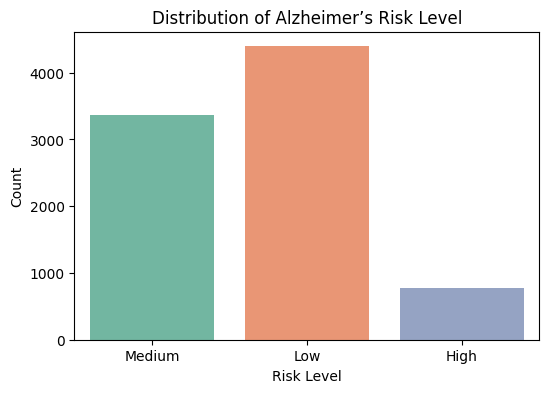

In [164]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='risk_level', palette = 'Set2')
plt.title("Distribution of Alzheimer’s Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Count")
print(df['risk_level'].value_counts())


# 2) Prakriti Vs Risk Level

prakriti_type
Pitta    2885
Vata     2866
Kapha    2771
Name: count, dtype: int64


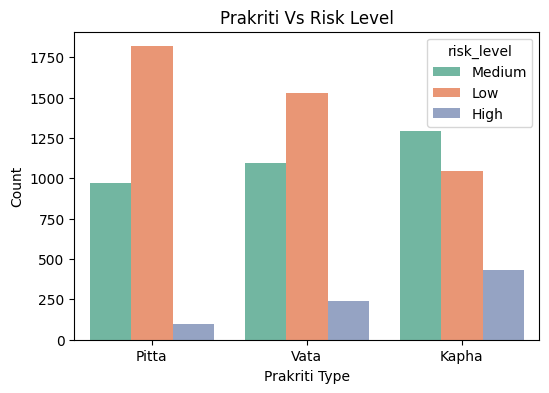

In [165]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='prakriti_type', hue='risk_level', palette = 'Set2')
plt.legend(title = 'risk_level' , frameon=True)
plt.title("Prakriti Vs Risk Level")
plt.xlabel("Prakriti Type")
plt.ylabel("Count")
print(df['prakriti_type'].value_counts())


## Correlation of Heatmap

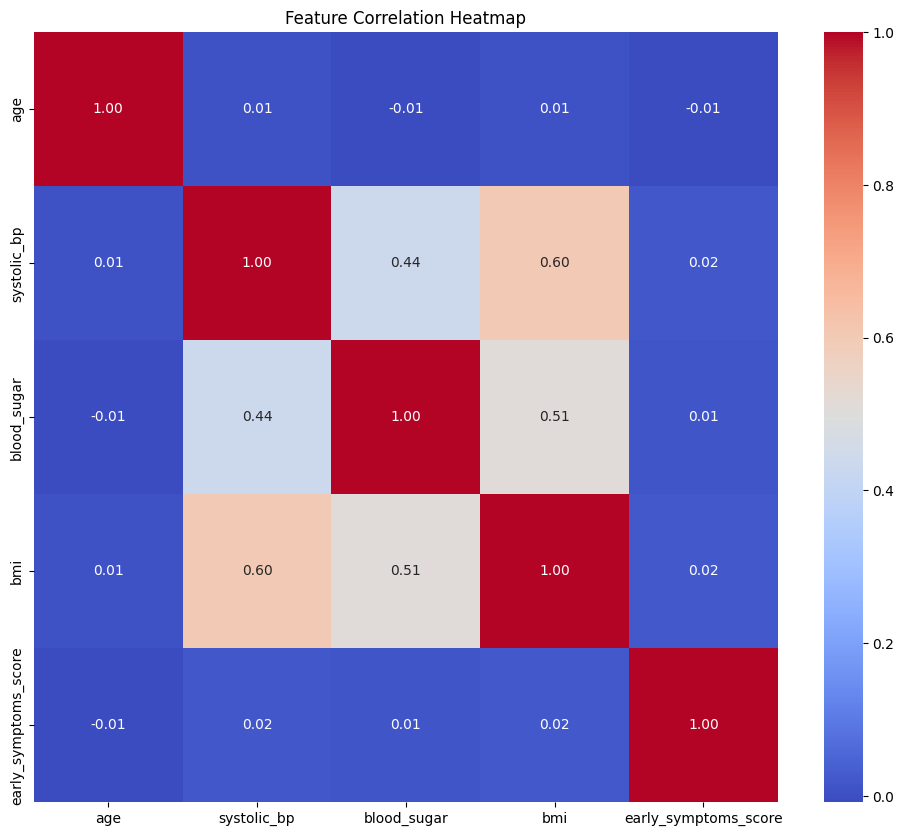

In [166]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [167]:
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
# categorical_cols.remove('risk_level') # Removed this line as it's causing an error

In [168]:
encoders = {}
df_encoded['chronic_conditions'] = df_encoded['chronic_conditions'].astype(str)

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le


target_encoder = LabelEncoder()
df_encoded['risk_level'] = target_encoder.fit_transform(df_encoded['risk_level'])
print("✅ Target Classes:", list(target_encoder.classes_))

✅ Target Classes: [np.int64(0), np.int64(1), np.int64(2)]


In [169]:
X = df_encoded.drop('risk_level', axis=1)
y = df_encoded['risk_level']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Before SMOTE:", y_train.value_counts())

Before SMOTE: risk_level
1    3514
2    2686
0     617
Name: count, dtype: int64


In [171]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("After SMOTE: ", y_train_bal.value_counts())

After SMOTE:  risk_level
1    3514
2    3514
0    3514
Name: count, dtype: int64


In [172]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

In [173]:
model.fit(X_train_bal, y_train_bal)

RandomForestClassifier(max_depth=10, random_state=42)

Accuracy: 0.7818181818181819

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.55      0.49       154
           1       0.89      0.86      0.88       879
           2       0.74      0.73      0.73       672

    accuracy                           0.78      1705
   macro avg       0.69      0.71      0.70      1705
weighted avg       0.79      0.78      0.79      1705



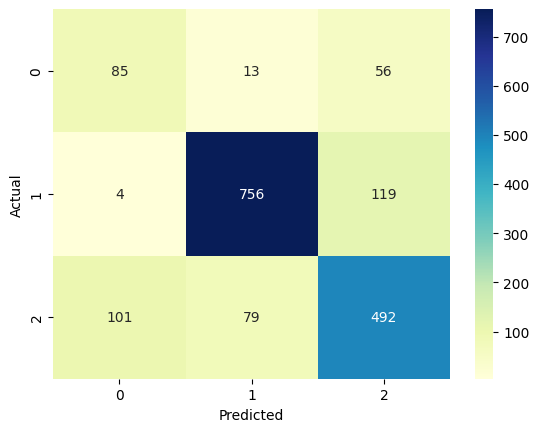

Confusion Matrix:


array([[ 85,  13,  56],
       [  4, 756, 119],
       [101,  79, 492]])

In [174]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Confusion Matrix:")
cm

In [175]:
joblib.dump(model, 'alzheimers_stage2_model.pkl')
print("Stage 2 Model saved as 'alzheimers_stage2_model.pkl'")


Stage 2 Model saved as 'alzheimers_stage2_model.pkl'


In [176]:
joblib.dump(encoders, 'stage2_encoders.pkl')
print("Encoder dictionary saved as 'stage2_encoders.pkl'")

Encoder dictionary saved as 'stage2_encoders.pkl'


In [177]:
test_input = {
 'prakriti_type': 'Vata',
    'age': 59,
    'gender': 'Female',
    'diet_type': 'Balanced',
    'sleep_quality': 'Average',
    'stress_level': 'High',
    'physical_activity': 'Moderate',
    'memory_loss': 'Mild',
    'confusion': 'Sometimes',
    'language_difficulty': 'Mild',
    'decision_making': 'Sharp',
    'repetition_behavior': 'No',
    'social_withdrawal': 'Sometimes',
    'mood_swings': 'Sometimes',
    'chronic_conditions': 'BP',
    'systolic_bp': 142,
    'blood_sugar': 118,
    'bmi': 19.5,
    'family_history': 'No'
}


In [178]:

test_df = pd.DataFrame([test_input])

In [179]:
def calculate_risk_score(row):
    score = 0
    if row['age'] > 65: score += 10
    if row['memory_loss'] == 'Mild': score += 15
    elif row['memory_loss'] == 'Severe': score += 20
    if row['confusion'] == 'Sometimes': score += 10
    elif row['confusion'] == 'Often': score += 15
    if row['language_difficulty'] == 'Mild': score += 5
    elif row['language_difficulty'] == 'Yes': score += 10
    if row['decision_making'] == 'Indecisive': score += 5
    elif row['decision_making'] == 'Poor': score += 10
    if row['repetition_behavior'] == 'Sometimes': score += 5
    elif row['repetition_behavior'] == 'Yes': score += 8
    if row['social_withdrawal'] == 'Sometimes': score += 5
    elif row['social_withdrawal'] == 'Yes': score += 7
    if row['mood_swings'] == 'Sometimes': score += 3
    elif row['mood_swings'] == 'Yes': score += 5
    if row['stress_level'] == 'Medium': score += 5
    elif row['stress_level'] == 'High': score += 8
    if row['sleep_quality'] == 'Poor': score += 7
    if row['physical_activity'] == 'Sedentary': score += 5
    if row['diet_type'] == 'Junk': score += 5
    if row['chronic_conditions'] in ['Diabetes', 'BP']: score += 10
    elif row['chronic_conditions'] == 'Both': score += 10
    if row['family_history'] == 'Yes': score += 10
    if row['systolic_bp'] > 140: score += 5
    if row['blood_sugar'] > 130: score += 5
    if row['bmi'] < 18 or row['bmi'] > 30: score += 5
    if row['prakriti_type'] == 'Vata': score *= 1.1
    elif row['prakriti_type'] == 'Kapha': score *= 1.05

    # Cap at 125, then normalize to 100
    score = min(score, 125)
    return round((score / 125) * 100, 2)


In [180]:
risk_score = round(calculate_risk_score(test_df.iloc[0].to_dict()), 2)
risk_level = get_risk_level(risk_score)
verdict = get_verdict(risk_score)
ayurveda_rec, allopathy_rec = get_recommendations(test_df['prakriti_type'].iloc[0], risk_level)

result = {
    "Risk Score (out of 100)": risk_score,
    "Risk Level": risk_level,
    "Verdict": verdict,
    "Ayurveda Recommendations": ayurveda_rec,
    "Allopathy Recommendations": allopathy_rec
}

import json
print(json.dumps(result, indent=2))


{
  "Risk Score (out of 100)": 53.68,
  "Risk Level": "Medium",
  "Verdict": "Needs attention",
  "Ayurveda Recommendations": "Brahmi, Ashwagandha, Abhyanga massage, warm diet",
  "Allopathy Recommendations": "Memory clinic referral, neurology consultation"
}
